In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import polars as pl
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "data/prostate_cancer_tabular"

In [3]:
if not os.path.exists(data_path):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("sajidsaifi/prostate-cancer", path=data_path, unzip=True)

In [4]:
csv_path = "Prostate_Cancer.csv"
df = pl.read_csv(os.path.join(data_path, csv_path))
df = df.select(pl.exclude("id"))
df = df.with_columns(pl.when(pl.col("diagnosis_result") == "M").then(1).otherwise(0).alias("diagnosis_result"))
df.head()

diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
i32,i64,i64,i64,i64,f64,f64,f64,f64
1,23,12,151,954,0.143,0.278,0.242,0.079
0,9,13,133,1326,0.143,0.079,0.181,0.057
1,21,27,130,1203,0.125,0.16,0.207,0.06
1,14,16,78,386,0.07,0.284,0.26,0.097
1,9,19,135,1297,0.141,0.133,0.181,0.059


In [5]:
train, test = train_test_split(df, test_size=0.25, random_state=491)

X_train = train.select(pl.exclude("diagnosis_result"))
y_train = train["diagnosis_result"]

X_test = test.select(pl.exclude("diagnosis_result"))
y_test = test["diagnosis_result"]

In [6]:
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000,
        random_state=491,
        fit_intercept=True,
    ),
)

In [7]:
param_grid = {"polynomialfeatures__degree": [1, 2, 3, 4, 5], "logisticregression__C": [0.01, 0.05, 0.1, 1.0, 5.0, 10.0]}

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)

results = pl.DataFrame(grid.cv_results_)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)
results[["params", "mean_test_score", "std_test_score", "rank_test_score"]]

Best params: {'logisticregression__C': 0.1, 'polynomialfeatures__degree': 2}
Best score: 0.8666666666666666


params,mean_test_score,std_test_score,rank_test_score
struct[2],f64,f64,i32
"{0.01,1}",0.746667,0.114698,26
"{0.01,2}",0.853333,0.026667,3
"{0.01,3}",0.84,0.053333,8
"{0.01,4}",0.84,0.090431,8
"{0.01,5}",0.84,0.053333,8
…,…,…,…
"{10.0,1}",0.826667,0.067987,14
"{10.0,2}",0.813333,0.077746,18
"{10.0,3}",0.76,0.03266,24


In [8]:
model = grid.best_estimator_
model.fit(X_train, y_train)

,steps,"[('polynomialfeatures', ...), ('standardscaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


In [9]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [10]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

Accuracy:  0.8400
Precision: 1.0000
Recall:    0.7647
F1-score:  0.8667
AUC:       0.9706


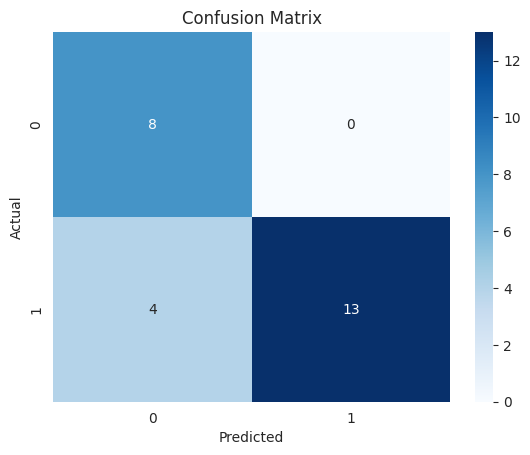


Classification report:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.76      0.87        17

    accuracy                           0.84        25
   macro avg       0.83      0.88      0.83        25
weighted avg       0.89      0.84      0.85        25



In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

In [12]:
poly = model.named_steps["polynomialfeatures"]
scaler = model.named_steps["standardscaler"]
clf = model.named_steps["logisticregression"]

X_train_pre = scaler.transform(poly.transform(X_train))
X_test_pre = scaler.transform(poly.transform(X_test))

y_train_bin = np.asarray(y_train).astype(float)
pls = PLSRegression(n_components=2, scale=False)
pls.fit(X_train_pre, y_train_bin)

T_train = pls.transform(X_train_pre)
T_test = pls.transform(X_test_pre)

x_min, x_max = T_train[:, 0].min() - 1.0, T_train[:, 0].max() + 3.0
y_min, y_max = T_train[:, 1].min() - 1.0, T_train[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
T_grid = np.c_[xx.ravel(), yy.ravel()]

X_grid_pre = pls.inverse_transform(T_grid)
Z = clf.predict_proba(X_grid_pre)[:, 1].reshape(xx.shape)

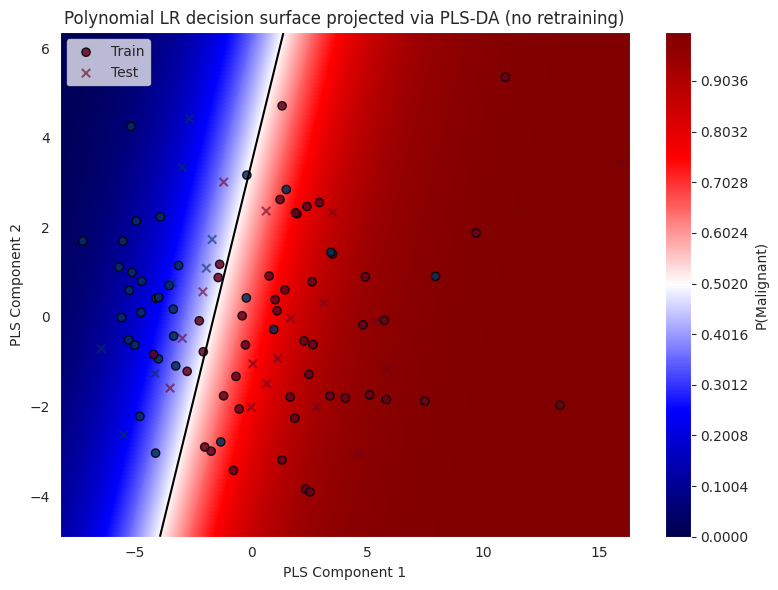

In [13]:
plt.figure(figsize=(8, 6))
cs = plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 250), cmap="seismic", alpha=1)
plt.colorbar(cs, label="P(Malignant)")

plt.scatter(
    T_train[:, 0], T_train[:, 1], c=y_train, cmap="RdBu_r", edgecolor="k", alpha=0.85, marker="o", label="Train"
)
plt.scatter(T_test[:, 0], T_test[:, 1], c=y_test, cmap="RdBu_r", alpha=0.6, marker="x", linewidths=1.5, label="Test")

plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=1.5)

plt.xlabel("PLS Component 1")
plt.ylabel("PLS Component 2")
plt.title("Polynomial LR decision surface projected via PLS-DA (no retraining)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()